# Bernstein-Vazirani Algorithm

This algorithm determines a n bit string (ex. "11001") using a function\
f<sub>s</sub>(x) = s<sub>0</sub>x<sub>0</sub> + s<sub>1</sub>x<sub>1</sub> + ... + s<sub>n</sub>x<sub>n</sub> mod 2\
\
Classicaly in order to retrieve s we have to query the function n times. In quantum computing using this algorithm\
we can determine s with 100% probability after only 1 query.

## Necessary Imports and Definitions

In [6]:
import numpy as np
from math import sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

unitary_backend = Aer.get_backend("unitary_simulator")
statevector_backend = Aer.get_backend("statevector_simulator")
backend = Aer.get_backend("qasm_simulator")

## Oracle from f<sub>s</sub>

This oracle maps the state |x>|y> to |x>|y XOR sx>

In [3]:
def get_oracle(s):
    """
    Makes a quantum gate that respects the oracle map
    and returns it
    """
    n = len(s)
    
    oracle = QuantumCircuit(n + 1)
    rev_s = s[::-1] # Reverse s to match qiskit's bit ordering
    
    for q in range(len(rev_s)):
        if rev_s[q] == "0":
            # if the bit is zero do nothing basically
            oracle.i(q)
        else:
            # if it's one apply CX gate (this acts as a classical XOR)
            oracle.cx(q, n)
            
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "B-V Oracle"
    
    return oracle_gate
    

## Algorithm

In [4]:
def bv_algorithm(oracle_gate, n):
    
    """
    Applies the bernstein-vazirani algorithm to n qubits with a give oracle gate
    that respects the conditions described above
    Returns the resulting circuit
    """
    
    # We need n qubits and an acillary for the output of oracle
    # and n classical bits for output of alogrithm
    qc = QuantumCircuit(n+1, n)
    
    # Prepare initial state i.e. |0>*n and the ancillary |-> 
    qc.h(n)
    qc.z(n)
    
    for q in range(n):
        qc.h(q)
    
    qc.barrier()
    
    # apply the oracle (works on n+1 qubits) to our circuit 
    qc.append(oracle_gate, range(n+1))
    
    qc.barrier()
    
    # apply hadamard again to the first n qubits
    for q in range(n):
        qc.h(q)
    
    qc.barrier()
    
    # measure the qubits and output their result to the classical registry
    qc.measure([i for i in range(n)], [i for i in range(n)])
    
    return qc

## Test

### 1. n = 2 and s = "11"

In [7]:
n = 2
s = "11"
oracle = get_oracle(s)
qc = bv_algorithm(oracle, n)
qc.draw()

┌───┐      ░ ┌─────────────┐ ░ ┌───┐ ░ ┌─┐   
q_0: ┤ H ├──────░─┤0            ├─░─┤ H ├─░─┤M├───
     ├───┤      ░ │             │ ░ ├───┤ ░ └╥┘┌─┐
q_1: ┤ H ├──────░─┤1 B-V Oracle ├─░─┤ H ├─░──╫─┤M├
     ├───┤┌───┐ ░ │             │ ░ └───┘ ░  ║ └╥┘
q_2: ┤ H ├┤ Z ├─░─┤2            ├─░───────░──╫──╫─
     └───┘└───┘ ░ └─────────────┘ ░       ░  ║  ║ 
c: 2/════════════════════════════════════════╩══╩═
                                             0  1

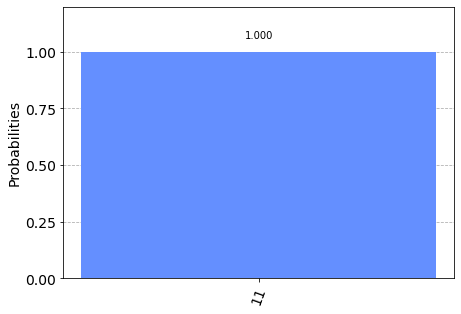

In [8]:
results = execute(qc, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

We get "11" with 100% accuracy, which is what we expected.

### 2. n = 4 and s = "1011"

In [9]:
n = 4
s = "1011"
oracle = get_oracle(s)
qc = bv_algorithm(oracle, n)
qc.draw()

┌───┐      ░ ┌─────────────┐ ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──────░─┤0            ├─░─┤ H ├─░─┤M├─────────
     ├───┤      ░ │             │ ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├──────░─┤1            ├─░─┤ H ├─░──╫─┤M├──────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├──────░─┤2 B-V Oracle ├─░─┤ H ├─░──╫──╫─┤M├───
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░─┤3            ├─░─┤ H ├─░──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │             │ ░ └───┘ ░  ║  ║  ║ └╥┘
q_4: ┤ H ├┤ Z ├─░─┤4            ├─░───────░──╫──╫──╫──╫─
     └───┘└───┘ ░ └─────────────┘ ░       ░  ║  ║  ║  ║ 
c: 4/════════════════════════════════════════╩══╩══╩══╩═
                                             0  1  2  3

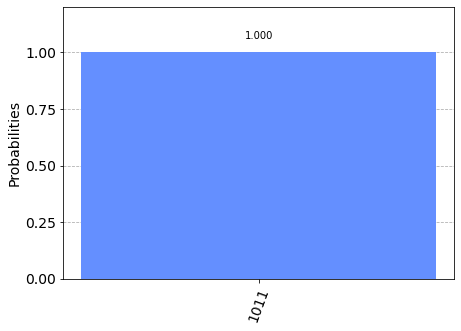

In [10]:
results = execute(qc, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

### 2. n = 8 and s = "11101101"

In [11]:
n = 8
s = "11101101"
oracle = get_oracle(s)
qc = bv_algorithm(oracle, n)
qc.draw()

┌───┐      ░ ┌─────────────┐ ░ ┌───┐ ░ ┌─┐                     
q_0: ┤ H ├──────░─┤0            ├─░─┤ H ├─░─┤M├─────────────────────
     ├───┤      ░ │             │ ░ ├───┤ ░ └╥┘┌─┐                  
q_1: ┤ H ├──────░─┤1            ├─░─┤ H ├─░──╫─┤M├──────────────────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║ └╥┘┌─┐               
q_2: ┤ H ├──────░─┤2            ├─░─┤ H ├─░──╫──╫─┤M├───────────────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║ └╥┘┌─┐            
q_3: ┤ H ├──────░─┤3            ├─░─┤ H ├─░──╫──╫──╫─┤M├────────────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├──────░─┤4 B-V Oracle ├─░─┤ H ├─░──╫──╫──╫──╫─┤M├─────────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├──────░─┤5            ├─░─┤ H ├─░──╫──╫──╫──╫──╫─┤M├──────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├──────░─┤6            ├─░─┤ H ├─░──╫──╫──╫──╫──╫──╫─┤M├───
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤ H ├──────░─┤7            ├─░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │             │ ░ └───┘ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
q_8: ┤ H ├┤ Z ├─░─┤8            ├─░───────░──╫──╫──╫──╫──╫──╫──╫──╫─
     └───┘└───┘ ░ └─────────────┘ ░       ░  ║  ║  ║  ║  ║  ║  ║  ║ 
c: 8/════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                             0  1  2  3  4  5  6  7

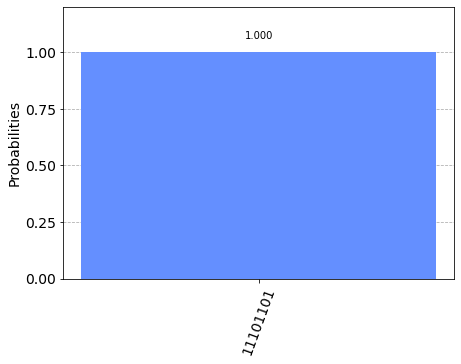

In [12]:
results = execute(qc, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

Even in our last 2 tests we get back the desired output with 100% accuracy.

## Test on a real Quantum Computer

In [13]:

# Import some more qiskit stuff
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor


In [14]:
n = 4
s = "1101"

oracle = get_oracle(s)
qc = bv_algorithm(oracle, n)
qc.draw()

┌───┐      ░ ┌─────────────┐ ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──────░─┤0            ├─░─┤ H ├─░─┤M├─────────
     ├───┤      ░ │             │ ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├──────░─┤1            ├─░─┤ H ├─░──╫─┤M├──────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├──────░─┤2 B-V Oracle ├─░─┤ H ├─░──╫──╫─┤M├───
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░─┤3            ├─░─┤ H ├─░──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │             │ ░ └───┘ ░  ║  ║  ║ └╥┘
q_4: ┤ H ├┤ Z ├─░─┤4            ├─░───────░──╫──╫──╫──╫─
     └───┘└───┘ ░ └─────────────┘ ░       ░  ║  ║  ║  ║ 
c: 4/════════════════════════════════════════╩══╩══╩══╩═
                                             0  1  2  3

In [15]:
# this code gets the least busy quantum computer with the necessary number of qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

c:\users\huskyez\appdata\local\programs\python\python38\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_valencia


In [16]:
job = execute(qc, backend=backend, shots=1024)
job_monitor(job, interval = 2)

Job Status: job has successfully run


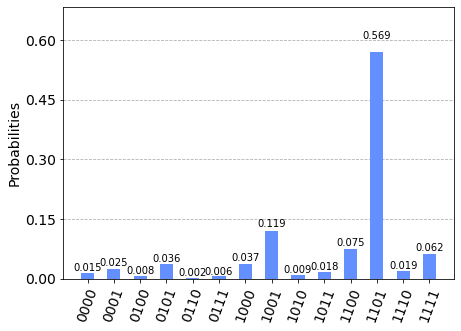

In [17]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

To be honest I didn't expect this bad of a result.\
It ooks like a random distribution with our desired output "1101" no being even close to the top.
I have no idea why this happened.

Note: the first time I implemented the circuit I first applied X and then H on the ancillary to bring it to the |-> state\
Running the algorithm on the simulator yields the expected results running it on a real QC however does not work\
The second implemntation, which should be equivalent is to first apply H and then Z to the ancillary, also resulting in the |-> state,\
the result can be seen above: the second implementation yields better results (like way better).

# Redefine circuit with XH instead of HZ for ancillary

In [18]:
def bv_algorithm(oracle_gate, n):
    
    """
    Applies the bernstein-vazirani algorithm to n qubits with a give oracle gate
    that respects the conditions described above
    Returns the resulting circuit
    """
    
    # We need n qubits and an acillary for the output of oracle
    # and n classical bits for output of alogrithm
    qc = QuantumCircuit(n+1, n)
    
    # Prepare initial state i.e. |0>*n and the ancillary |-> 
    qc.x(n)
    qc.h(n)
    
    for q in range(n):
        qc.h(q)
    
    qc.barrier()
    
    # apply the oracle (works on n+1 qubits) to our circuit 
    qc.append(oracle_gate, range(n+1))
    
    qc.barrier()
    
    # apply hadamard again to the first n qubits
    for q in range(n):
        qc.h(q)
    
    qc.barrier()
    
    # measure the qubits and output their result to the classical registry
    qc.measure([i for i in range(n)], [i for i in range(n)])
    
    return qc

In [19]:
n = 4
s = "1101"

oracle = get_oracle(s)
qc = bv_algorithm(oracle, n)
qc.draw()

┌───┐      ░ ┌─────────────┐ ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──────░─┤0            ├─░─┤ H ├─░─┤M├─────────
     ├───┤      ░ │             │ ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├──────░─┤1            ├─░─┤ H ├─░──╫─┤M├──────
     ├───┤      ░ │             │ ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├──────░─┤2 B-V Oracle ├─░─┤ H ├─░──╫──╫─┤M├───
     ├───┤      ░ │             │ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░─┤3            ├─░─┤ H ├─░──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │             │ ░ └───┘ ░  ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─░─┤4            ├─░───────░──╫──╫──╫──╫─
     └───┘└───┘ ░ └─────────────┘ ░       ░  ║  ║  ║  ║ 
c: 4/════════════════════════════════════════╩══╩══╩══╩═
                                             0  1  2  3

In [24]:
# this code gets the least busy quantum computer with the necessary number of qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-10-14 15:59:35,462: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_athens


In [21]:
job = execute(qc, backend=backend, shots=1024)
job_monitor(job, interval = 2)

Job Status: job has successfully run


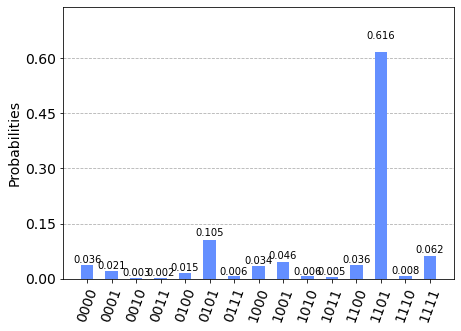

In [22]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

To my surpirse this is still ok. Unlike last night when I ran it and the results where all over the place. (The correct answer should be 1101 still)
![WTF](BV_XH_Valencia.png)\
This was run on ibmq_valencia with the same parameters and functions as above